In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# define the minimum confidence (to filter weak detections), 
# Non-Maximum Suppression (NMS) threshold, and the green color
confidence_thresh = 0.5
NMS_thresh = 0.3
green = (0, 255, 0)

In [2]:
# Load the image and get its dimensions
image = cv2.imread("imgs/telefono.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# resize the image to 25% of its original size
# image = cv2.resize(image,
#                     (int(image.shape[0] * 0.25),
#                      int(image.shape[1] * 0.25)))
#image = cv2.resize(image, (224, 224))

# get the image dimensions
h = image.shape[0]
w = image.shape[1]

# load the class labels the model was trained on
classes_path = "../../darknet/data/coco.names"
with open(classes_path, "r") as f:
    classes = f.read().strip().split("\n")

In [3]:
# load the configuration and weights from disk
yolo_config = "../../darknet/cfg/yolov3.cfg"
yolo_weights = "../../darknet/yolov3.weights"

# load YOLOv3 network pre-trained on the COCO dataset
net = cv2.dnn.readNetFromDarknet(yolo_config, yolo_weights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [4]:
# net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
# net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

In [5]:
# Get the name of all the layers in the network
layer_names = net.getLayerNames()
# Get the names of the output layers
unconnected_out_layers = net.getUnconnectedOutLayers()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# create a blob from the image
blob = cv2.dnn.blobFromImage(
    image, 1 / 255, (416, 416), swapRB=False, crop=False)
# pass the blob through the network and get the output predictions
net.setInput(blob)
outputs = net.forward(output_layers)
output_layers

['yolo_82', 'yolo_94', 'yolo_106']

In [6]:
# create empty lists for storing the bounding boxes, confidences, and class IDs
boxes = []
confidences = []
class_ids = []

# loop over the output predictions
for output in outputs:
    # loop over the detections
    for detection in output:
        # get the class ID and confidence of the dected object
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence  = scores[class_id]

        # we keep the bounding boxes if the confidence (i.e. class probability) 
        # is greater than the minimum confidence 
        if confidence > confidence_thresh:
            # perform element-wise multiplication to get
            # the coordinates of the bounding box
            box = [int(a * b) for a, b in zip(detection[0:4], [w, h, w, h])]
            center_x, center_y, width, height = box

            # get the top-left corner of the bounding box
            x = int(center_x - (width / 2))
            y = int(center_y - (height / 2))

            # append the bounding box, confidence, and class ID to their respective lists
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, width, height])

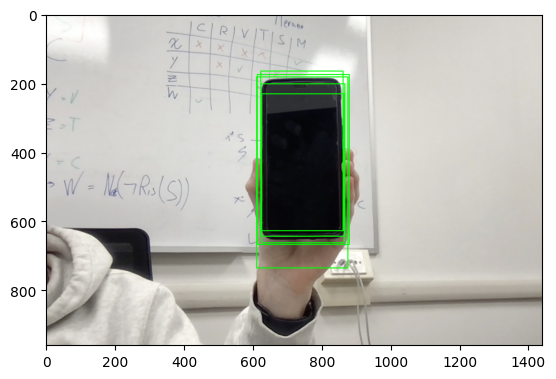

In [7]:
# draw the bounding boxes on a copy of the original image
# before applying non-maxima suppression
image_copy = image.copy()
for box in boxes:
    x, y, width, height = box
    cv2.rectangle(image_copy, (x, y), (x + width, y + height), green, 2)
    
# show the output image
# cv2.imshow("Before NMS", image_copy)
plt.figure()
plt.imshow(
    image_copy.astype(dtype="uint8"),
    interpolation=None,
)
plt.show()

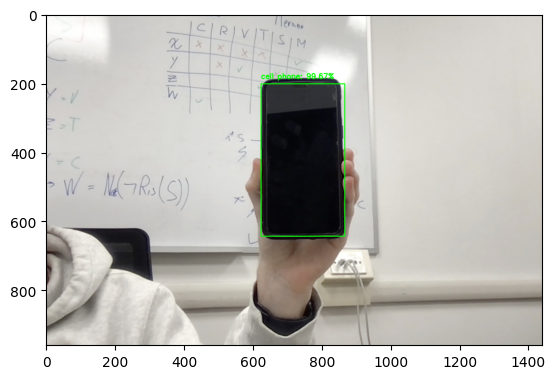

In [8]:
# apply non-maximum suppression to remove weak bounding boxes that overlap with others.
indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_thresh, NMS_thresh)
indices = indices.flatten()
for i in indices:
    (x, y, w, h) = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
    cv2.rectangle(image, (x, y), (x + w, y + h), green, 2)
    text = f"{classes[class_ids[i]]}: {confidences[i] * 100:.2f}%"
    cv2.putText(image, text, (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, green, 2)
    
# show the output image
plt.figure()
plt.imshow(
    image.astype(dtype="uint8"),
    interpolation=None,
)
plt.show()